# TREx ASI - Starter Functions to Organize and Plot Data

The Transition Region Explorer (TREx) network consists of ground-based auroral remote sensing instruments, including all-sky imagers (ASIs) and spectrographs, distributed across central and northern Canada. It provides continuous, high-resolution, quantitative, multi-wavelength auroral observations (see Gillies et al., 2019; Gillies et al., 2020; Liang et al., 2023). You can find a bit more information about the TREx project here: https://www.ucalgary.ca/aurora/projects/trex

There is also a data portal where you can take a look at some of the data from the different instruments: https://data-portal.phys.ucalgary.ca/

Here's a quick visualization that will help you get a sense of where the sites are and when data is available: 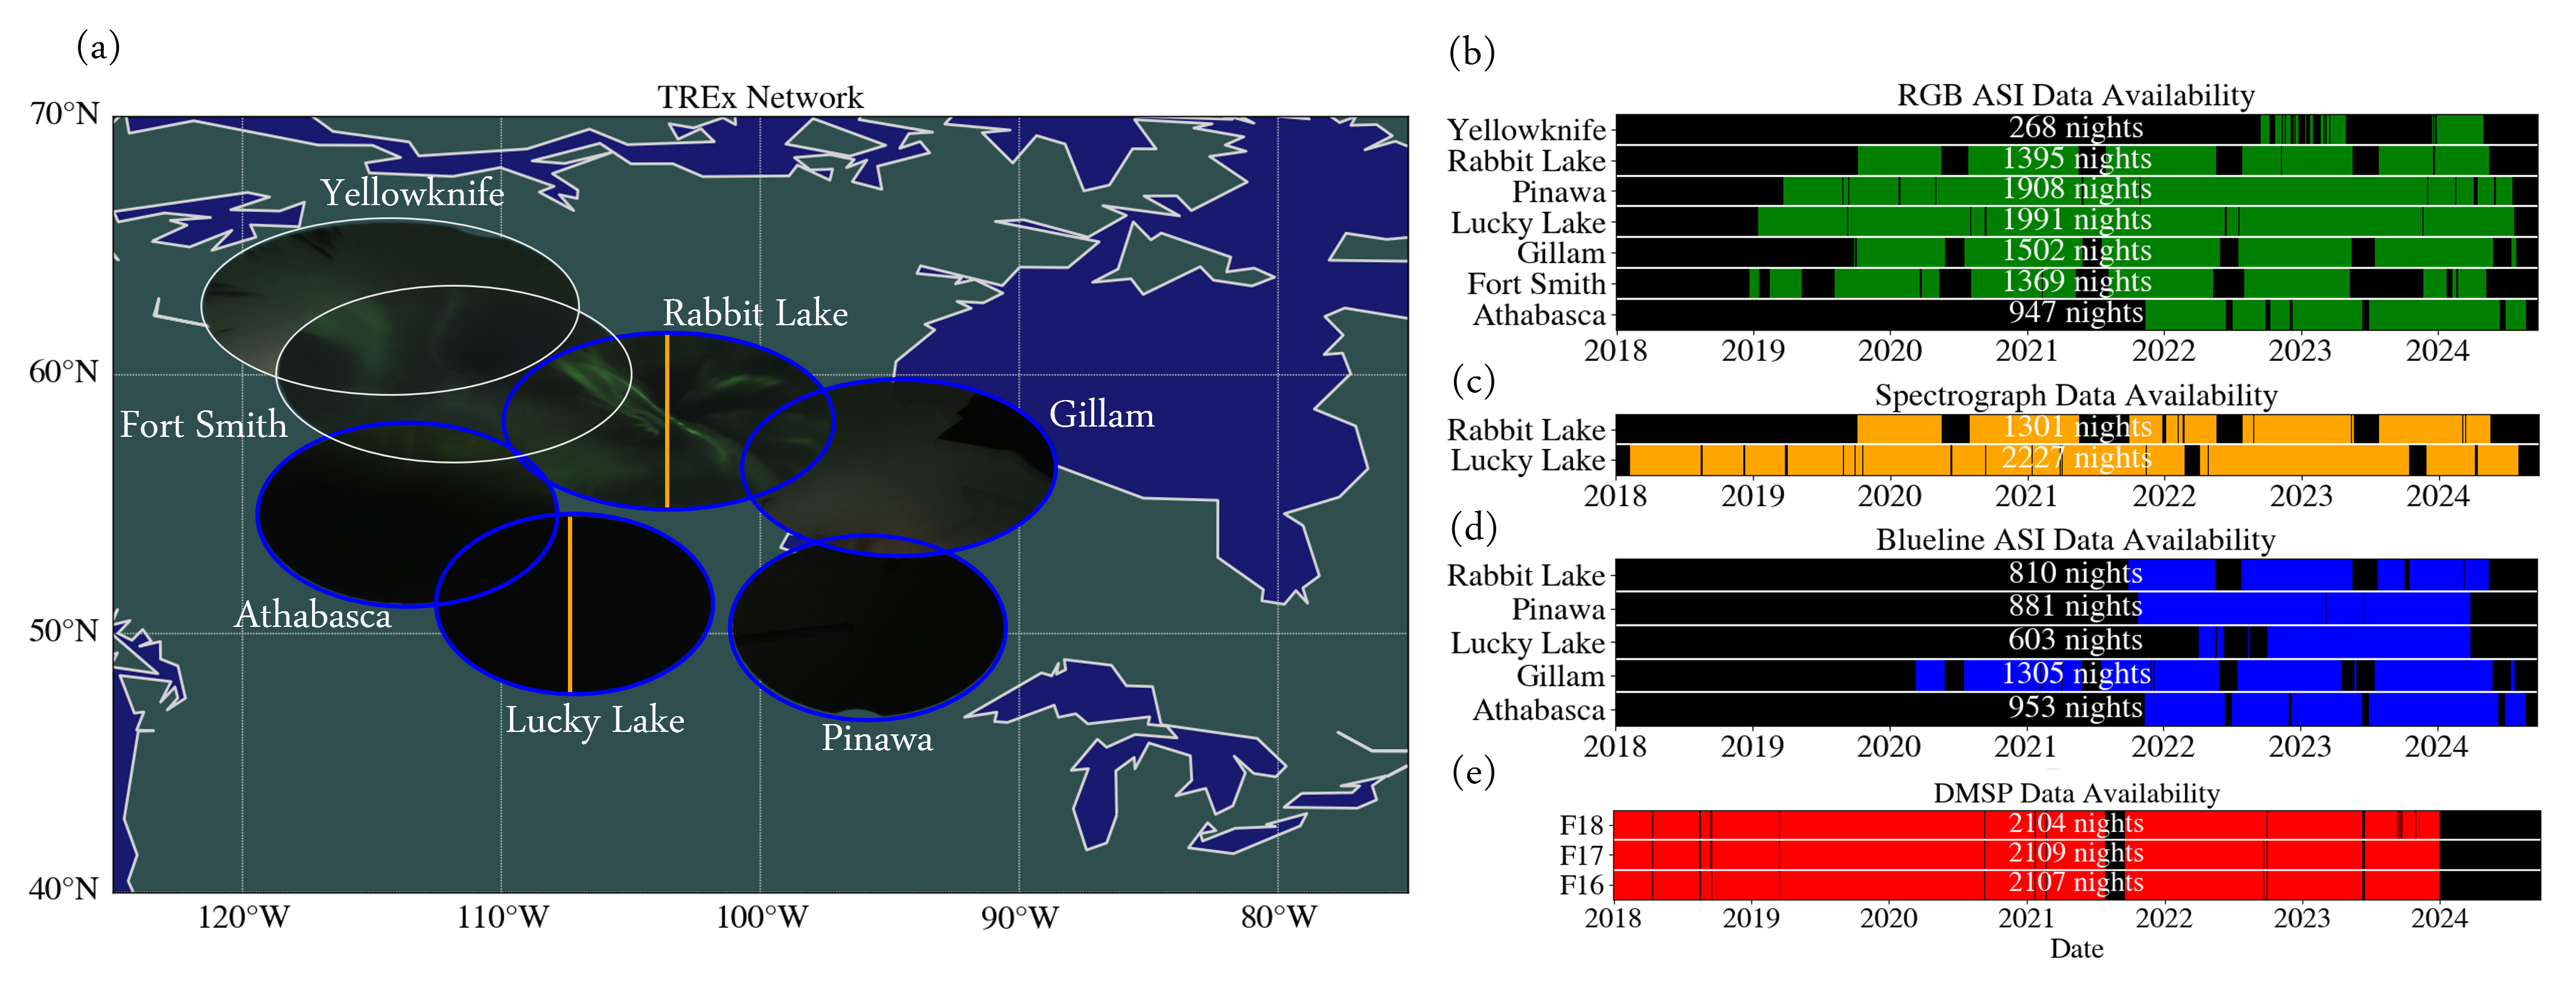

For this project, we'll start by focusing on the RGB ASI data from Yellowknife on August 30, 2024. As a quick visualization, you can check out the movie available on the TREx data portal here: https://data-portal.phys.ucalgary.ca/archive/trex_rgb/movies?datestring=2024%2F08%2F30

If you just need to download a small amount of data, you can find it here: https://data.phys.ucalgary.ca/sort_by_project/ (go to TREx -> RGB -> stream0. Then choose the date and time to get data from.). There is one file for each minute. The code included below can download one day of data from one site at a time, and can be adapted if needed.  

You'll also need to download the RGB skymaps (https://data.phys.ucalgary.ca/sort_by_project/TREx/RGB/skymaps/). These will help us map the pixels in the file to places on the sky based on an assumption of where the light is coming from. 

I've written some code which will let you turn the data into a format that you can more easily work with. 

Try the import statements here first. If anything doesn't work, try downloading the package using the command: !pip install package_name

In [1]:
#imports:

#for dealing with data:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import xarray as xr

#for dealing with files:
import os
import re
from scipy.io import readsav
import h5py
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
from urllib.parse import urljoin, urlparse
import time

#for plotting (the rcParams updates are my personal perference to change font and increase fontsize)
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 24,\
                     'xtick.labelsize' : 24,\
                     'ytick.labelsize' : 24,\
                     'axes.titlesize' : 24,\
                     'axes.labelsize' : 24,\
                     'date.autoformatter.minute': '%H:%M' })

First, here's the code to download the data and the skymaps. You'll need to change the filepaths for where you want to download these, either on your local machine or to a class repository. Note: each file is ~10 MB. That isn't huge, but since there's a file for every minute, it adds up quickly. Hopefully you have enough storage for just 1-2 days of data on your local machine, but if not we can chat about how to work around that. 

In [2]:
def download_trex_rgb_asi_files(date: datetime, site: str, outdir: str = './trex-rgb-asi_data'):
    """
    Download all available RGB ASI .h5 files for a given date and site from the TREx RGB archive.

    Parameters:
        date (datetime): Date of interest.
        site (str): One of 'rabb', 'luck', 'gill', 'yknf', 'atha', 'fsmi', 'pina', or 'all'.
        outdir (str): Output directory to save files.
    """
    base_url = "https://data.phys.ucalgary.ca/sort_by_project/TREx/RGB/stream0"
    year = date.strftime("%Y")
    month = date.strftime("%m")
    day = date.strftime("%d")
    date_str = date.strftime("%Y%m%d")

    headers = {'User-Agent': 'Mozilla/5.0'}

    # primarily look at yknf (yellow knife) and fsmi (fort smith) now
    all_sites = ['rabb', 'luck', 'gill', 'yknf', 'atha', 'fsmi', 'pina']

    if site == 'all':
        sites_to_use = all_sites
    elif site in all_sites:
        sites_to_use = [site]
    else:
        raise ValueError(f"Site must be one of {all_sites + ['all']}")

    day_url = f"{base_url}/{year}/{month}/{day}/"

    try:
        print(f"\nAccessing {day_url}...")
        response = requests.get(day_url, headers=headers)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, "html.parser")
        subdirs = [a['href'].strip('/') for a in soup.find_all('a', href=True) if a['href'].endswith('/')]

        for s in sites_to_use:
            # Look for matching subdirs like 'gill_rgb-04'
            matching_dirs = [d for d in subdirs if d.startswith(f"{s}_rgb-")]
            if not matching_dirs:
                print(f"No matching RGB camera folder found for site '{s}' on {date_str}.")
                continue

            for camera_dir in matching_dirs:
                camera_url = day_url + camera_dir + "/"

                try:
                    cam_resp = requests.get(camera_url, headers=headers)
                    cam_resp.raise_for_status()
                    cam_soup = BeautifulSoup(cam_resp.text, "html.parser")

                    hour_dirs = [a['href'].strip('/') for a in cam_soup.find_all('a', href=True) if a['href'].startswith("ut")]

                    for hour_dir in hour_dirs:
                        file_url = camera_url + hour_dir + "/"

                        try:
                            file_resp = requests.get(file_url, headers=headers)
                            file_resp.raise_for_status()
                            file_soup = BeautifulSoup(file_resp.text, "html.parser")

                            h5_links = [
                                a['href'] for a in file_soup.find_all('a', href=True)
                                if a['href'].endswith(".h5") and a['href'].startswith(date_str)
                            ]

                            if not h5_links:
                                continue

                            save_dir = os.path.join(outdir, date_str, s)
                            os.makedirs(save_dir, exist_ok=True)

                            print(f"Downloading {len(h5_links)} files from {file_url}...")
                            for file_name in tqdm(h5_links, desc=f"{s.upper()} {hour_dir}"):
                                file_full_url = file_url + file_name
                                local_path = os.path.join(save_dir, file_name)

                                try:

                                    if os.path.exists(local_path):
                                        # Skip existing file
                                        continue
                                    with requests.get(file_full_url, headers=headers, stream=True) as r:
                                        r.raise_for_status()
                                        with open(local_path, "wb") as f:
                                            for chunk in r.iter_content(chunk_size=8192):
                                                f.write(chunk)
                                except requests.RequestException as e:
                                    print(f"Failed to download {file_name}: {e}")

                        except requests.RequestException as e:
                            print(f"Failed to access hour directory {file_url}: {e}")

                except requests.RequestException as e:
                    print(f"Failed to access camera directory {camera_url}: {e}")

    except requests.RequestException as e:
        print(f"Failed to access day directory {day_url}: {e}")

def recursive_get_sav_links(base_url="https://data.phys.ucalgary.ca/sort_by_project/TREx/RGB/skymaps/", delay=0.1):
    """
    Recursively traverse the directory tree starting from `base_url`
    and return all .sav file URLs.
    """
    sav_links = []

    headers = {'User-Agent': 'Mozilla/5.0'}

    def walk(url):
        try:
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()
        except requests.RequestException as e:
            print(f"[ERROR] Failed to fetch {url}: {e}")
            return

        soup = BeautifulSoup(response.text, 'html.parser')
        for a_tag in soup.find_all('a', href=True):
            href = a_tag['href']
            if href in ['../', './']:
                continue
            full_url = url + href

            if href.endswith('.sav'):
                sav_links.append(full_url)
            elif href.endswith('/'):
                # Recurse into subdirectory
                walk(full_url)
                time.sleep(delay)

    walk(base_url)
    return sav_links

def download_all_trex_rgb_skymaps(output_dir='./trex-rgb-asi_data', base_url="https://data.phys.ucalgary.ca/sort_by_project/TREx/RGB/skymaps/"):
    """
    Recursively download all .sav files under `base_url` into `output_dir`.

    Parameters:
        base_url (str): The root URL to start looking for .sav files.
        output_dir (str): Local directory to save downloaded files.
    """
    os.makedirs(output_dir, exist_ok=True)

    print(f"[INFO] Getting list of .sav files from {base_url} ...")
    all_sav_urls = recursive_get_sav_links(base_url)
    print(f"[INFO] Found {len(all_sav_urls)} files to download.")

    headers = {'User-Agent': 'Mozilla/5.0'}

    for url in tqdm(all_sav_urls, desc="Downloading .sav files"):
        filename = os.path.basename(url)
        filepath = os.path.join(output_dir, filename)

        # Skip if already downloaded
        if os.path.exists(filepath):
            continue

        try:
            r = requests.get(url, stream=True, headers=headers, timeout=10)
            r.raise_for_status()
            with open(filepath, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
        except requests.RequestException as e:
            print(f"[ERROR] Failed to download {url}: {e}")


In [3]:
#just need to run this once on any machine you want to use:
download_all_trex_rgb_skymaps(output_dir='./trex-rgb-asi_data') #BY DEFAULT, DOWNLOADS TO CURRENT DIRECTORY - PROBABLY WANT TO CHANGE THAT!

[INFO] Getting list of .sav files from https://data.phys.ucalgary.ca/sort_by_project/TREx/RGB/skymaps/ ...


KeyboardInterrupt: 

In [ ]:
#download a day of data:
test_date = datetime(2024,8,30)
test_site = 'yknf'
test_dir = './trex-rgb-asi_data/yknf' #CHANGE THIS BASED ON WHERE YOU WANT TO PUT THE DATA!

download_trex_rgb_asi_files(test_date,test_site,test_dir)

First, make sure you've downloaded all of the skymaps. Those are what we use to get the 'metadata' about how the pixels in the images can be projected to the sky. You can find them all here: https://data.phys.ucalgary.ca/sort_by_project/TREx/RGB/skymaps/ 

Information about the skymaps can be found here: https://data.phys.ucalgary.ca/sort_by_project/other/documentation/skymap_file_description.pdf

Below, the first set of functions will go into the directory where you keep your skymaps and make a list of them for easy reference. Then, for the later functions, given a date and time, they will know exactly which skymap to pull information from. 

The next set of functions will load a datafile into an xarray, which is a useful data struture for keeping track of data in many dimensions with different coordinates. These images have pixel coordinates (x,y), a time coordinate, and the color channels (R, G, B).

In [ ]:
def rgb_asi_skymap_parse_valid_time(timestr):
    """Convert a string like '2023040803' to datetime."""
    return datetime.strptime(timestr, "%Y%m%d%H")

def rgb_asi_skymap_extract_site(filename):
    """Extract site name from filename like rgb_skymap_rabb_20240827-+_v01.sav"""
    match = re.search(r"rgb_skymap_([a-z]+)_\d+", filename)
    return match.group(1) if match else None

def build_rgb_asi_skymap_lookup_table(directory='./trex-rgb-asi_data'):
    """
    Scan all .sav skymap files in a directory and extract site, start, and end times. 
    NOTE: For last 'end time' for each site, it is set as today at midnight.
    This script should be rerun whenever a new skymap is added or when using more recent data. 

    Returns:
        pd.DataFrame with columns: 'site', 'valid_start', 'valid_end', 'filename'
    """
    records = []

    for file in os.listdir(directory):
        if not file.endswith(".sav"):
            continue

        filepath = os.path.join(directory, file)
        try:
            data = readsav(filepath, verbose=False)
            skymap_values = data['skymap'][0][0]
            start_str = skymap_values['VALID_INTERVAL_START'][0]
            end_str = skymap_values['VALID_INTERVAL_STOP'][0]

            if isinstance(start_str, bytes):
                start_str = start_str.decode()
            if isinstance(end_str, bytes):
                end_str = end_str.decode()

            start_dt = rgb_asi_skymap_parse_valid_time(start_str)
            site = rgb_asi_skymap_extract_site(file)

            if site is not None:
                # Add a 'raw_end_str' column to keep '+' values
                records.append({
                    "site": site,
                    "valid_start": start_dt,
                    "valid_end": None if end_str == '+' else parse_valid_time(end_str),
                    "filename": file
                })

        except Exception as e:
            print(f"Error reading {file}: {e}")

    # Convert to DataFrame
    df = pd.DataFrame(records)
    
    # Sort by site and start time
    df = df.sort_values(by=["site", "valid_start"]).reset_index(drop=True)
    
    # Fill missing valid_end with the next valid_start for same site
    for i in range(len(df) - 1):
        if pd.isnull(df.loc[i, "valid_end"]) and df.loc[i, "site"] == df.loc[i + 1, "site"]:
            df.loc[i, "valid_end"] = df.loc[i + 1, "valid_start"]
    
    # For the very last skymap per site, fill with today at midnight UTC
    df["valid_end"] = df["valid_end"].fillna(pd.to_datetime(datetime.utcnow().date()))  # today at midnight UTC

    return df

def rgb_asi_parse_effective_time(timestr):
    """Parse timestamp strings like '2022-12-26 13:02:00.150280 UTC'."""
    if isinstance(timestr, bytes):
        timestr = timestr.decode()

    timestr = timestr.strip().replace(' UTC', '')
    return datetime.strptime(timestr, "%Y-%m-%d %H:%M:%S.%f")

def rgb_asi_select_matching_skymap(skymap_df, site, timestamp):
    for _, row in skymap_df.iterrows():
        if row['site'] == site and row['valid_start'] <= timestamp <= row['valid_end']:
            return row['filename']
    return None

def load_rgb_asi_skymap(filepath):
    data = readsav(filepath, verbose=False)
    data = data['skymap']

    skymap = {
        # Site location
        "site_lat": float(data['SITE_MAP_LATITUDE'][0]),
        "site_lon": float(data['SITE_MAP_LONGITUDE'][0]),
        "site_alt": float(data['SITE_MAP_ALTITUDE'][0]),

        # Preprocessing helpers
        "ignore_mask": data["FULL_IGNORE"][0],      # int mask
        "subtract_array": data["FULL_SUBTRACT"][0], # for background correction?
        "multiply_array": data["FULL_MULTIPLY"][0], # for flat-field or gain?

        # Spatial direction (for each pixel)
        "elevation": data["FULL_ELEVATION"][0],     # degrees
        "azimuth": data["FULL_AZIMUTH"][0],         # degrees

        # Geolocation mapping
        "map_altitudes": data["FULL_MAP_ALTITUDE"][0],             # (3,)
        "map_latitude": data["FULL_MAP_LATITUDE"][0],              # (3, x, y)
        "map_longitude": data["FULL_MAP_LONGITUDE"][0],            # (3, x, y)
    }

    return skymap

def load_1min_rgb_asi_h5_to_xarray(rgb_filepath):
    """Load a TREx RGB ASI .h5 file into an xarray Dataset."""
    filename = os.path.basename(rgb_filepath)
    site = filename.split('_')[2]
    timestamp_str = filename.split('_')[0] + filename.split('_')[1]  # e.g., 202212261302
    file_time = datetime.strptime(timestamp_str, "%Y%m%d%H%M")

    with h5py.File(rgb_filepath, 'r') as f:
        # Read image cube
        # shape: (x, y, RGB, time)
        image_cube = np.array(f['data/images'])  # shape: (480, 553, 3, 20)
        
        # Read times
        times = np.array(f['data/timestamp'])
        
        # Transpose to (time, RGB, x, y)
        image_cube = np.transpose(image_cube, (3, 2, 0, 1))  # (20, 3, 480, 553)

        # Pull timestamps from attributes of frame datasets
        frame_keys = sorted(
            (k for k in f['metadata/frame'].keys() if k.startswith('frame')),
            key=lambda x: int(x.replace("frame", ""))
        )
        times_start = []
        times_end = []

        for frame in frame_keys:
            frame_path = f'metadata/frame/{frame}'
            times_start.append(rgb_asi_parse_effective_time(f[frame_path].attrs['image_request_start_timestamp']))
            times_end.append(rgb_asi_parse_effective_time(f[frame_path].attrs['image_effective_end_timestamp']))

    # Build dataset
    ds = xr.Dataset(
        data_vars=dict(
            image=(["times", "channel", "x", "y"], image_cube)  # RGB image cube
        ),
        coords=dict(
            times=times,
            time_start=("times",times_start),
            time_end=("times", times_end),
            channel=["R", "G", "B"]
        ),
        attrs=dict(
            site=site,
        )
    )

    return ds

def list_rgb_asi_files_for_hour(data_dir, site, date, hour):
    """
    Build list of ASI RGB .h5 files for a given site, date, and hour.

    Parameters:
        data_dir (str): Base path to RGB files (should include YYYY/MM/DD/site_rgb-XX/)
        site (str): Site code, e.g., 'rabb'
        date (datetime.date): Date of interest
        hour (int): Hour of interest (0–23)

    Returns:
        List of full file paths for that hour (one per minute)
    """
    date_str = date.strftime("%Y%m%d")
    hour_str = f"{hour:02d}"

    # Construct full path to the correct subdirectory
    subdir = os.path.join(data_dir, date_str, site)

    if not os.path.exists(subdir):
        raise FileNotFoundError(f"No directory found: {subdir}")

    files = sorted([
        os.path.join(subdir, f)
        for f in os.listdir(subdir)
        if f.endswith(".h5")
        and f.startswith(f"{date_str}_{hour_str}")
        and f"_{site}_" in f
    ])

    return files


def load_rgb_asi_hour_to_xarray(site, date, hour, skymap_lookup_df, data_dir='../../../../mydisks/disk1/lcgasque/trex_rgb_asi_data/', skymap_dir='../../../../mydisks/disk1/lcgasque/trex_rgb_asi_skymaps/'):
    """
    Loads one hour of RGB ASI data for a given site into a single xarray Dataset,
    and appends skymap info.

    Parameters:
        site (str): e.g., 'rabb'
        date (datetime): e.g., datetime(2022, 12, 26)
        hour (int): e.g., 13
        data_dir (str): Path to flat directory of local .h5 ASI files --> dir containing direct download from 
        skymap_lookup_df (pd.DataFrame): Lookup table of skymaps
        skymap_dir (str): Path to directory containing .sav skymap files

    Returns:
        xr.Dataset: with time, image, and skymap coordinates merged
    """
    # Get list of files for that hour
    file_list = list_rgb_asi_files_for_hour(data_dir, site, date, hour)
    if len(file_list) == 0:
        raise FileNotFoundError(f"No RGB ASI files found for {site} on {date} at hour {hour}")

    # Read and stack all files into one xarray
    datasets = []
    for f in file_list:
        try:
            ds = load_1min_rgb_asi_h5_to_xarray(f)
            datasets.append(ds)
        except Exception as e:
            print(f"Failed to load {f}: {e}")

    if len(datasets) == 0:
        raise RuntimeError(f"All file reads failed for {site} {date} hour {hour}")

    ds_all = xr.concat(datasets, dim="times")

    # Drop duplicate times (just in case)
    ds_all = ds_all.sortby("times").drop_duplicates("times")

    #Load skymap once and add skymap variables to ds_all
    skymap_file = rgb_asi_select_matching_skymap(skymap_lookup_df, site, date)
    skymap_path = os.path.join(skymap_dir, skymap_file)
    skymap = load_rgb_asi_skymap(skymap_path)
    
    ds_all.attrs["site_latitude"] = skymap["site_lat"]
    ds_all.attrs["site_longitude"] = skymap["site_lon"]
    ds_all.attrs["site_altitude_m"] = skymap["site_alt"]
    ds_all.attrs["skymap_file"] = skymap_file

    ds_all["elevation"] = (("x", "y"), skymap["elevation"])
    ds_all["azimuth"] = (("x", "y"), skymap["azimuth"])
    ds_all["lat_110"] = (("x", "y"), skymap["map_latitude"][1,1:,1:])
    ds_all["lon_110"] = (("x", "y"), skymap["map_longitude"][1,1:,1:])

    return ds_all

In [ ]:
#load an hour of data
site = 'yknf'
date = datetime(2024,8,30)
hour = 5 #this is in UT

rgb_asi_skymap_lookup_df = build_rgb_asi_skymap_lookup_table(directory='./trex-rgb-asi_data') #CHANGE TO YOUR SKYMAP DIRECTORY!
rgb_asi_ds = load_rgb_asi_hour_to_xarray(site, date, hour, rgb_asi_skymap_lookup_df,data_dir='./trex-rgb-asi_data', skymap_dir='./trex-rgb-asi_data') #CHANGE DIRECTORIES!

The next set of code will allow you to plot the images in polar coordinates. 

In [ ]:
#make a polar plot in azimuth and elevation
time_index = 400

R = rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
G = rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
B = rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values

azimuth_plot = rgb_asi_ds['azimuth'].values*np.pi/180 #convert to radians too
elevation_plot = rgb_asi_ds['elevation'].values

#start with just the individual channels
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))
scat = ax.scatter(azimuth_plot,elevation_plot,c=R.reshape(-1, 3),s=1,cmap='Reds_r')
ax.set_ylim(90, 0)
ax.set_theta_zero_location("N") # Puts 0° (North) at the top
ax.set_theta_direction(-1) # Clockwise rotation (like a compass)
fig.colorbar(scat, ax=ax)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))
scat = ax.scatter(azimuth_plot,elevation_plot,c=G.reshape(-1, 3),s=1,cmap='Greens_r')
ax.set_ylim(90, 0)
ax.set_theta_zero_location("N") # Puts 0° (North) at the top
ax.set_theta_direction(-1) # Clockwise rotation (like a compass)
fig.colorbar(scat, ax=ax)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))
scat = ax.scatter(azimuth_plot,elevation_plot,c=B.reshape(-1, 3),s=1,cmap='Blues_r')
ax.set_ylim(90, 0)
ax.set_theta_zero_location("N") # Puts 0° (North) at the top
ax.set_theta_direction(-1) # Clockwise rotation (like a compass)
fig.colorbar(scat, ax=ax)

# Extract time and format it
raw_time = rgb_asi_ds.times.values[time_index]
time_obj = pd.to_datetime(raw_time.decode("utf-8").replace(" UTC", ""))
time_str = time_obj.strftime("%b. %d, %Y %H:%M:%S UT")

# Site label - can adjust to allow for different sites!
site_name = "Yellowknife"

#now make a 'true color' version combining all three channels
rgb = np.stack([R, G, B], axis=-1)  # shape: (x, y, 3)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))
scat = ax.scatter(azimuth_plot,elevation_plot,c=rgb.reshape(-1, 3)/256,s=1)
ax.set_theta_zero_location("N") # Puts 0° (North) at the top
ax.set_theta_direction(-1) # Clockwise rotation (like a compass)
ax.set_ylim(90, 0);
ax.set_title(f"{site_name} – {time_str}", pad=30);

## Animations: Yellowknife & Fort Smith
1. adjust the contrast of the RGB image
2. make sure that the timeline of the yellow knife and the fort smith data line up
3. generate folder of images containing all of the adjusted RGB images w/ the same contrast
   - define some fixed range (min and max pixel intensity
   - apply the scaling / contrast adjustmnent to every frame
   - SO won't distort the actual variations in the aurora
4. repeat (1-3) for fort smith data
5. create animation
   - split the corresponding time stamp images together OR
   - create seperate animations for YKNF and FSMI, then splice the 2 animations together
   - use matplotlib: https://matplotlib.org/stable/gallery/animation/dynamic_image.html

In [ ]:
# look at hr 7 because there is more activity, to adjust the contrast

#load an hour of data
site = 'yknf'
date = datetime(2024,8,30)
hour = 7 #this is in UT

rgb_asi_skymap_lookup_df = build_rgb_asi_skymap_lookup_table(directory='./trex-rgb-asi_data') #CHANGE TO YOUR SKYMAP DIRECTORY!
rgb_asi_ds = load_rgb_asi_hour_to_xarray(site, date, hour, rgb_asi_skymap_lookup_df,data_dir='./trex-rgb-asi_data', skymap_dir='./trex-rgb-asi_data') #CHANGE DIRECTORIES!

In [ ]:
# plot only RGB
time_index = 400

R = rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
G = rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
B = rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values

azimuth_plot = rgb_asi_ds['azimuth'].values*np.pi/180 #convert to radians too
elevation_plot = rgb_asi_ds['elevation'].values

# Extract time and format it
raw_time = rgb_asi_ds.times.values[time_index]
time_obj = pd.to_datetime(raw_time.decode("utf-8").replace(" UTC", ""))
time_str = time_obj.strftime("%b. %d, %Y %H:%M:%S UT")

# Site label - can adjust to allow for different sites!
site_name = "Yellowknife"

#now make a 'true color' version combining all three channels
rgb = np.stack([R, G, B], axis=-1)  # shape: (x, y, 3)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))
scat = ax.scatter(azimuth_plot,elevation_plot,c=rgb.reshape(-1, 3)/256,s=1)
ax.set_theta_zero_location("N") # Puts 0° (North) at the top
ax.set_theta_direction(-1) # Clockwise rotation (like a compass)
ax.set_ylim(90, 0);
ax.set_title(f"{site_name} – {time_str}", pad=30);
